# **TCC - Ciências de dados e big data - PUC MG**
## ***Modelagem Preditiva para Análise de Churn: Um Estudo de Caso na Indústria de Telecomunicações***
###Aluno: Elcio Rezende Junior
###Turma: 2022

## **Sumário**
###**1 - Coleta de Dados**
###**2 - Processamento/tratamendo de dados para análise e exploração**
###**3 - Análise e Exploração dos Dados**
####*3.1 - Churn*
####*3.2 - City*
####*3.3 - Ternune Months*
####*3.4 - Contract type*
####*3.5 - Gender*
####*3.6 - Payment Method*
####*3.7 - Internet Service*
####*3.8 - Internet Service / Payment Method*
###**4 - Processamento/tratamendo de dados para o modelo**
###**5 - O Modelo**
####*5.1 - Logistic Regression*
####*5.2 - Decision Tree*
####*5.3 - Random Forest*
####*5.4 - Comparação Entre Modelos*
###**6 - Cross Validation**
####*6.1 - Logistic Regression*
####*6.2 - Decision Tree*
####*6.3 - Random Forest*
####*6.4 - Comparação Entre Modelos Após o Tuning*
###**7 - Refinamento do Modelo Escolhido**
###**8 - Cadastro e Teste Para Novos Clientes**

## **1 - Coleta de Dados**


### PySpark

O PySpark, construído sobre o Apache Spark, é uma poderosa biblioteca que proporciona a flexibilidade do Python juntamente com a capacidade de processamento distribuído do Spark. Essa combinação única permite que manipulemos e analisemos grandes volumes de dados de maneira escalável e eficiente.


No projeto em questão, optou-se por aproveitar a potência do PySpark para processar grandes conjuntos de dados de maneira distribuída. Uma peça fundamental nessa jornada é o conceito de SparkSession, uma interface única que lhes permite interagir e coordenar operações com o Apache Spark de forma eficiente e simplificada.

Os dados serão coletados a partir do site kaggle.

https://www.kaggle.com/datasets/yeanzc/telco-customer-churn-ibm-dataset

O dataset consiste em dados de clientes de uma prestadora de serviços de telefonia e internet.

Será feito o download pela plataforma no formato XLSX, o primeiro tratamento é transforma-lo em CSV utilizando Microsoft Excel.

A partir disso, será feito o upload para um repositório do colab para então ler os dados utilizando o spark.

In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=21f52fec78df5ab05c87e910e874b1e5a2fa55f6a7b7833b6ba2fa4662507c5c
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as f
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [ ]:
spark = SparkSession.builder.master('local[*]').appName("TCC Ciencias de Dados e Big Data - Elcio Junior").getOrCreate()

In [ ]:
spark

In [ ]:
telco_customer = '/content/Telco_customer_churn.csv'

In [ ]:
df_telco_customer = spark.read.csv(telco_customer, sep=';', header=True, inferSchema=True)

In [ ]:
df_telco_customer.show()

+----------+-----+-------------+----------+---------------+--------+--------------------+---------+-----------+------+--------------+-------+----------+-------------+-------------+----------------+----------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+-----------------+--------------------+---------------+-------------+-----------+-----------+-----------+----+--------------------+
|CustomerID|Count|      Country|     State|           City|Zip Code|            Lat Long| Latitude|  Longitude|Gender|Senior Citizen|Partner|Dependents|Tenure Months|Phone Service|  Multiple Lines|Internet Service|    Online Security|      Online Backup|  Device Protection|       Tech Support|       Streaming TV|   Streaming Movies|      Contract|Paperless Billing|      Payment Method|Monthly Charges|Total Charges|Churn Label|Churn Value|Churn Score|CLTV|        Churn Reason|
+----------+-----+-------------+------

In [ ]:
df_telco_customer.printSchema()

root
 |-- CustomerID: string (nullable = true)
 |-- Count: integer (nullable = true)
 |-- Country: string (nullable = true)
 |-- State: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Zip Code: integer (nullable = true)
 |-- Lat Long: string (nullable = true)
 |-- Latitude: string (nullable = true)
 |-- Longitude: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Senior Citizen: string (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- Tenure Months: integer (nullable = true)
 |-- Phone Service: string (nullable = true)
 |-- Multiple Lines: string (nullable = true)
 |-- Internet Service: string (nullable = true)
 |-- Online Security: string (nullable = true)
 |-- Online Backup: string (nullable = true)
 |-- Device Protection: string (nullable = true)
 |-- Tech Support: string (nullable = true)
 |-- Streaming TV: string (nullable = true)
 |-- Streaming Movies: string (nullable = true)
 |-- Contract:

In [ ]:
df_telco_customer.count()

7043

In [ ]:
df_telco_customer.groupBy('Churn Label').count().show()

+-----------+-----+
|Churn Label|count|
+-----------+-----+
|         No| 5174|
|        Yes| 1869|
+-----------+-----+



## **2 - Processamento/tratamendo de dados para analise e exploração**

In [ ]:
contagem_nulos_por_coluna = df_telco_customer.select([f.sum(f.when(f.col(c).isNull(), 1).otherwise(0)).alias(c) for c in df_telco_customer.columns])

In [ ]:
contagem_nulos_por_coluna.show()

+----------+-----+-------+-----+----+--------+--------+--------+---------+------+--------------+-------+----------+-------------+-------------+--------------+----------------+---------------+-------------+-----------------+------------+------------+----------------+--------+-----------------+--------------+---------------+-------------+-----------+-----------+-----------+----+------------+
|CustomerID|Count|Country|State|City|Zip Code|Lat Long|Latitude|Longitude|Gender|Senior Citizen|Partner|Dependents|Tenure Months|Phone Service|Multiple Lines|Internet Service|Online Security|Online Backup|Device Protection|Tech Support|Streaming TV|Streaming Movies|Contract|Paperless Billing|Payment Method|Monthly Charges|Total Charges|Churn Label|Churn Value|Churn Score|CLTV|Churn Reason|
+----------+-----+-------+-----+----+--------+--------+--------+---------+------+--------------+-------+----------+-------------+-------------+--------------+----------------+---------------+-------------+---------

In [ ]:
media_nulos_churn_reason = df_telco_customer.select((1 - (f.col("Churn Reason").isNotNull().cast("int"))).alias("nulo")).agg({"nulo": "mean"}).collect()[0]["avg(nulo)"]

In [ ]:
print(f"Média de nulos em 'Churn Reason': {media_nulos_churn_reason:.2%}")

Média de nulos em 'Churn Reason': 73.46%


In [ ]:
colunas_para_remover = ['CustomerID', 'Count','Country', 'State', 'Zip Code', 'Lat Long', 'Latitude', 'Longitude', 'Total Charges','Churn Score', 'CLTV','Churn Reason']

In [ ]:
df_telco_customer = df_telco_customer.drop(*colunas_para_remover)

In [ ]:
df_telco_customer = df_telco_customer.rdd.zipWithIndex().map(lambda x: (x[1], ) + x[0]).toDF(["id"] + df_telco_customer.columns)

In [ ]:
df_telco_customer.show()

+---+---------------+------+--------------+-------+----------+-------------+-------------+----------------+----------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+-----------------+--------------------+---------------+-----------+-----------+
| id|           City|Gender|Senior Citizen|Partner|Dependents|Tenure Months|Phone Service|  Multiple Lines|Internet Service|    Online Security|      Online Backup|  Device Protection|       Tech Support|       Streaming TV|   Streaming Movies|      Contract|Paperless Billing|      Payment Method|Monthly Charges|Churn Label|Churn Value|
+---+---------------+------+--------------+-------+----------+-------------+-------------+----------------+----------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+-----------------+--------------------+---------------+--------

## **3 - Análise e Exploração dos Dados**

#### 3.1 - Churn

In [ ]:
Churn_Label_counts = df_telco_customer.groupBy("Churn Label").count().toPandas()

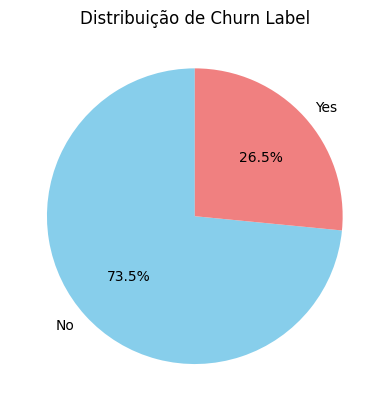

In [ ]:
total = Churn_Label_counts["count"].sum()
Churn_Label_counts["percentage"] = (Churn_Label_counts["count"] / total) * 100

colors = ['skyblue', 'lightcoral']
plt.pie(Churn_Label_counts["count"], labels=Churn_Label_counts["Churn Label"], autopct='%1.1f%%', startangle=90, colors=colors)
plt.title("Distribuição de Churn Label")
plt.show()

#### 3.2 - City

In [ ]:
count_distinct_city = df_telco_customer.select("City").distinct().count()
print(f"Contagem Distinta na Coluna 'City': {count_distinct_city}")

Contagem Distinta na Coluna 'City': 1129


In [ ]:
df_telco_customer_pd = df_telco_customer.toPandas()

In [ ]:
resultados_cities = df_telco_customer_pd.groupby('City').agg(
    Count=('Churn Value', 'count'),
    Churn_Rate=('Churn Value', 'mean')
).reset_index()
resultados_cities = resultados_cities.sort_values(by='Count', ascending=False)
resultados_cities.columns = ['City', 'Count', 'Churn Rate']
resultados_cities['Churn Rate'] = resultados_cities['Churn Rate'].round(2)
resultados_cities.head()

,City,Count,Churn Rate
562,Los Angeles,305,0.30
869,San Diego,150,0.33
878,San Jose,112,0.26
855,Sacramento,108,0.24
872,San Francisco,104,0.30


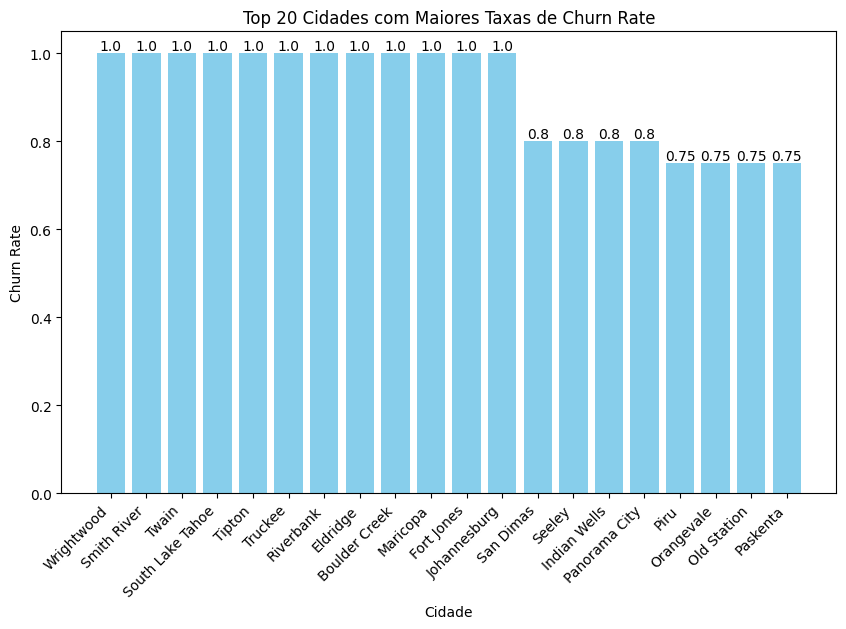

In [ ]:
top_20_cities_churn_rate = resultados_cities.nlargest(20, 'Churn Rate')

plt.figure(figsize=(10, 6))
bars = plt.bar(top_20_cities_churn_rate['City'], top_20_cities_churn_rate['Churn Rate'], color='skyblue')
plt.title('Top 20 Cidades com Maiores Taxas de Churn Rate')
plt.xlabel('Cidade')
plt.ylabel('Churn Rate')
plt.xticks(rotation=45, ha='right')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.show()

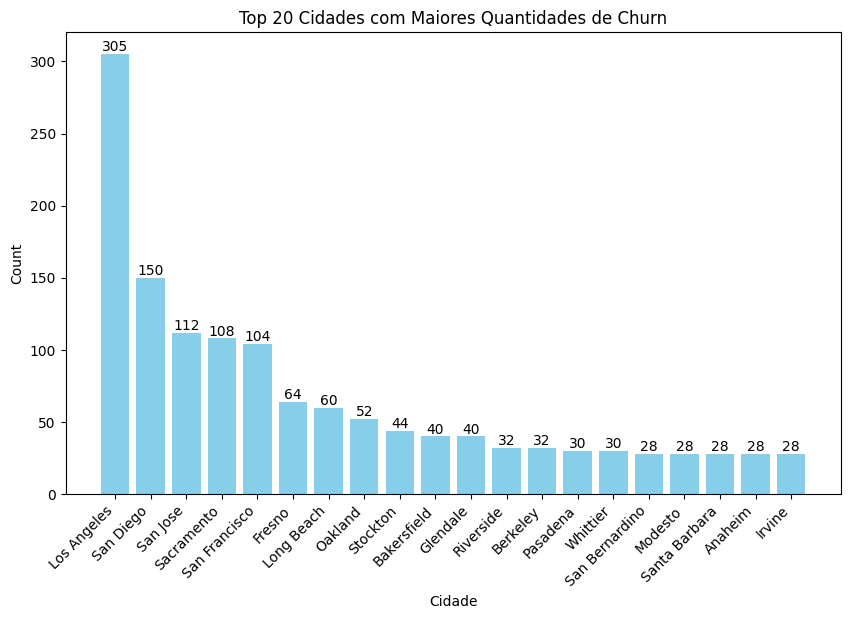

In [ ]:
top_20_cities_churn_count = resultados_cities.nlargest(20, 'Count')

plt.figure(figsize=(10, 6))
bars = plt.bar(top_20_cities_churn_count['City'], top_20_cities_churn_count['Count'], color='skyblue')
plt.title('Top 20 Cidades com Maiores Quantidades de Churn')
plt.xlabel('Cidade')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.show()

####3.3 - Ternune Months

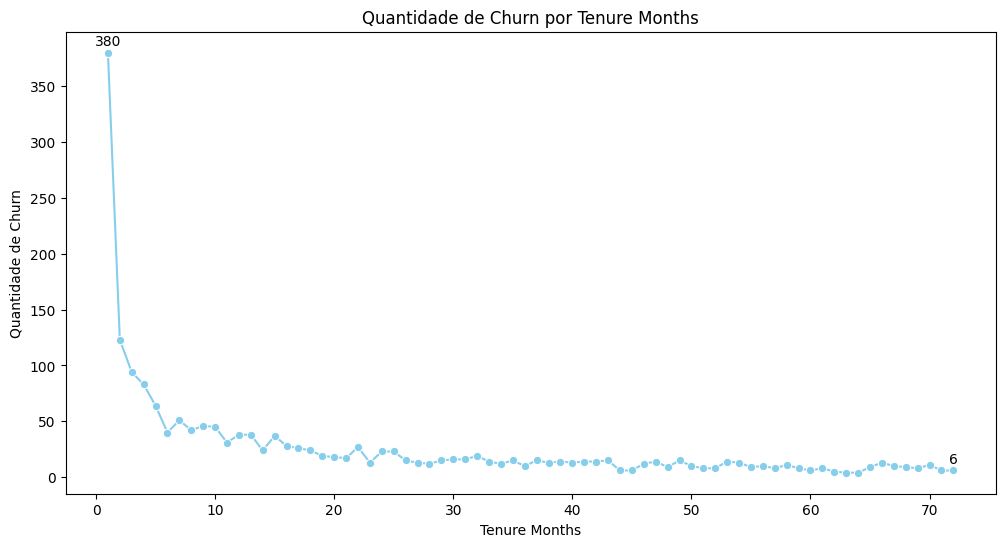

In [ ]:
churn_yes_counts = df_telco_customer_pd[df_telco_customer_pd['Churn Label'] == 'Yes'].groupby('Tenure Months')['Churn Label'].count().reset_index()

selected_points = churn_yes_counts[churn_yes_counts['Tenure Months'].isin([1, 72])]

plt.figure(figsize=(12, 6))
ax = sns.lineplot(x='Tenure Months', y='Churn Label', data=churn_yes_counts, marker='o', color='skyblue')

for i, txt in enumerate(selected_points['Churn Label']):
    ax.annotate(txt, (selected_points['Tenure Months'].iloc[i], txt), textcoords="offset points", xytext=(0,5), ha='center')

plt.title('Quantidade de Churn por Tenure Months')
plt.xlabel('Tenure Months')
plt.ylabel('Quantidade de Churn')
plt.show()

####3.4 - Contract type

In [ ]:
Contract_Label_counts = df_telco_customer_pd[df_telco_customer_pd['Churn Label'] == 'Yes'].groupby('Contract')['Churn Label'].count().reset_index()

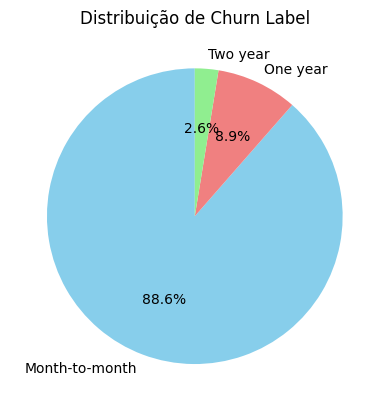

In [ ]:
colors = ['skyblue', 'lightcoral', 'lightgreen']

plt.pie(Contract_Label_counts["Churn Label"], labels=Contract_Label_counts["Contract"], autopct='%1.1f%%', startangle=90, colors=colors)

plt.title("Distribuição de Churn Label")

plt.show()

####3.5 - Gender

In [ ]:
resultados_gender = df_telco_customer_pd.groupby('Gender')['Churn Value'].agg(
    Total_Count='count',
    Churn_Count=lambda x: (x == 1).sum(),
    Churn_Rate=lambda x: (x == 1).mean()
).reset_index()


resultados_gender['No_Churn_Count'] = resultados_gender['Total_Count'] - resultados_gender['Churn_Count']
resultados_gender['No_Churn_Rate'] = 1 - resultados_gender['Churn_Rate']


resultados_gender = resultados_gender[['Gender', 'Total_Count', 'Churn_Count', 'No_Churn_Count', 'Churn_Rate', 'No_Churn_Rate']]


resultados_gender['Churn_Rate'] = resultados_gender['Churn_Rate'].round(2)
resultados_gender['No_Churn_Rate'] = resultados_gender['No_Churn_Rate'].round(2)


resultados_gender

,Gender,Total_Count,Churn_Count,No_Churn_Count,Churn_Rate,No_Churn_Rate
0,Female,3488,939,2549,0.27,0.73
1,Male,3555,930,2625,0.26,0.74


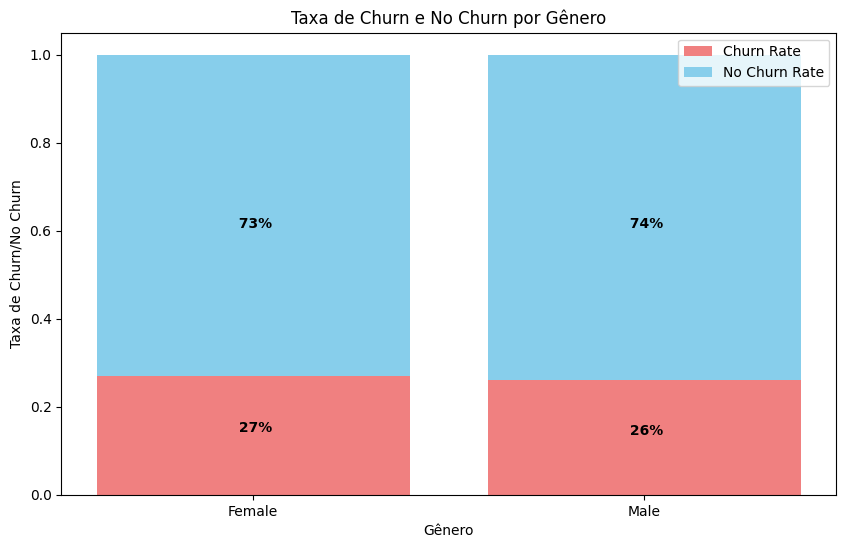

In [ ]:
labels = resultados_gender['Gender']
churn_rate = resultados_gender['Churn_Rate']
no_churn_rate = resultados_gender['No_Churn_Rate']


fig, ax = plt.subplots(figsize=(10, 6))
bars_churn = ax.bar(labels, churn_rate, label='Churn Rate', color='lightcoral')
bars_no_churn = ax.bar(labels, no_churn_rate, bottom=churn_rate, label='No Churn Rate', color='skyblue')


for bar_churn, bar_no_churn in zip(bars_churn, bars_no_churn):
    height_churn = bar_churn.get_height()
    height_no_churn = bar_no_churn.get_height()
    total_height = height_churn + height_no_churn
    ax.text(bar_churn.get_x() + bar_no_churn.get_width() / 2, total_height * 0.6, f'{height_no_churn: .0%}',
            ha='center', va='bottom', color='black', fontweight='bold')

    ax.text(bar_no_churn.get_x() + bar_churn.get_width() / 2, height_churn / 2, f'{height_churn: .0%}',
            ha='center', va='bottom', color='black', fontweight='bold')


ax.set_ylabel('Taxa de Churn/No Churn')
ax.set_xlabel('Gênero')
ax.set_title('Taxa de Churn e No Churn por Gênero')
ax.legend()

plt.show()


####3.6 - Payment Method

In [ ]:
resultados_payment = df_telco_customer_pd.groupby('Payment Method')['Churn Value'].agg(
    Total_Count='count',
    Churn_Count=lambda x: (x == 1).sum(),
    Churn_Rate=lambda x: (x == 1).mean()
).reset_index()


resultados_payment['No_Churn_Count'] = resultados_payment['Total_Count'] - resultados_payment['Churn_Count']
resultados_payment['No_Churn_Rate'] = 1 - resultados_payment['Churn_Rate']


resultados_payment = resultados_payment[['Payment Method', 'Total_Count', 'Churn_Count', 'No_Churn_Count', 'Churn_Rate', 'No_Churn_Rate']]


resultados_payment['Churn_Rate'] = resultados_payment['Churn_Rate'].round(2)
resultados_payment['No_Churn_Rate'] = resultados_payment['No_Churn_Rate'].round(2)
resultados_payment = resultados_payment.sort_values(by='Churn_Rate', ascending=False)

resultados_payment

,Payment Method,Total_Count,Churn_Count,No_Churn_Count,Churn_Rate,No_Churn_Rate
2,Electronic check,2365,1071,1294,0.45,0.55
3,Mailed check,1612,308,1304,0.19,0.81
0,Bank transfer (automatic),1544,258,1286,0.17,0.83
1,Credit card (automatic),1522,232,1290,0.15,0.85


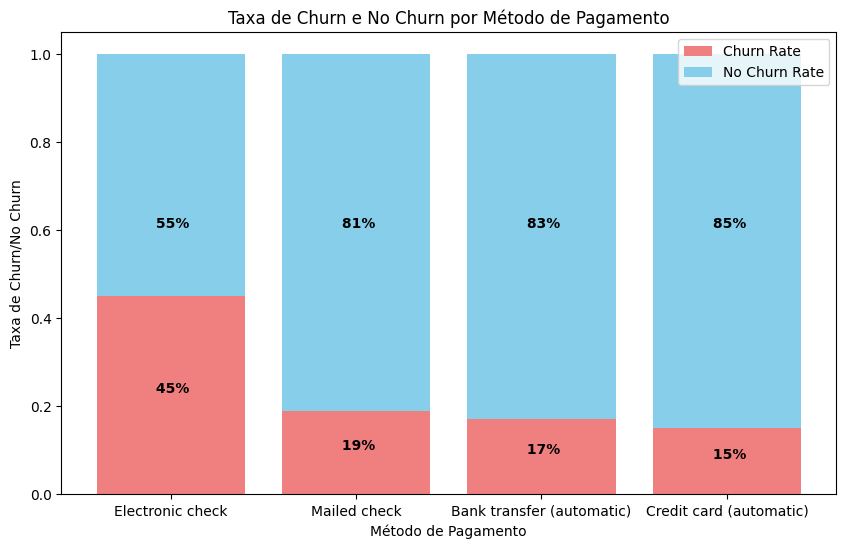

In [ ]:

labels_payment = resultados_payment['Payment Method']
churn_rate_payment = resultados_payment['Churn_Rate']
no_churn_rate_payment = resultados_payment['No_Churn_Rate']

fig, ax = plt.subplots(figsize=(10, 6))
bars_churn_payment = ax.bar(labels_payment, churn_rate_payment, label='Churn Rate', color='lightcoral')
bars_no_churn_payment = ax.bar(labels_payment, no_churn_rate_payment, bottom=churn_rate_payment, label='No Churn Rate', color='skyblue')

for bar_churn_payment, bar_no_churn_payment in zip(bars_churn_payment, bars_no_churn_payment):
    height_churn_payment = bar_churn_payment.get_height()
    height_no_churn_payment = bar_no_churn_payment.get_height()
    total_height_payment = height_churn_payment + height_no_churn_payment
    ax.text(bar_churn_payment.get_x() + bar_no_churn_payment.get_width() / 2, total_height_payment * 0.6, f'{height_no_churn_payment: .0%}',
            ha='center', va='bottom', color='black', fontweight='bold')

    ax.text(bar_no_churn_payment.get_x() + bar_churn_payment.get_width() / 2, height_churn_payment / 2, f'{height_churn_payment: .0%}',
            ha='center', va='bottom', color='black', fontweight='bold')

ax.set_ylabel('Taxa de Churn/No Churn')
ax.set_xlabel('Método de Pagamento')
ax.set_title('Taxa de Churn e No Churn por Método de Pagamento')
ax.legend()

plt.show()


####3.7 - Internet Service

In [ ]:
resultados_internet = df_telco_customer_pd.groupby('Internet Service')['Churn Value'].agg(
    Total_Count='count',
    Churn_Count=lambda x: (x == 1).sum(),
    Churn_Rate=lambda x: (x == 1).mean()
).reset_index()


resultados_internet['No_Churn_Count'] = resultados_internet['Total_Count'] - resultados_internet['Churn_Count']
resultados_internet['No_Churn_Rate'] = 1 - resultados_internet['Churn_Rate']


resultados_internet = resultados_internet[['Internet Service', 'Total_Count', 'Churn_Count', 'No_Churn_Count', 'Churn_Rate', 'No_Churn_Rate']]


resultados_internet['Churn_Rate'] = resultados_internet['Churn_Rate'].round(2)
resultados_internet['No_Churn_Rate'] = resultados_internet['No_Churn_Rate'].round(2)
resultados_internet = resultados_internet.sort_values(by='Churn_Rate', ascending=False)

resultados_internet

,Internet Service,Total_Count,Churn_Count,No_Churn_Count,Churn_Rate,No_Churn_Rate
1,Fiber optic,3096,1297,1799,0.42,0.58
0,DSL,2421,459,1962,0.19,0.81
2,No,1526,113,1413,0.07,0.93


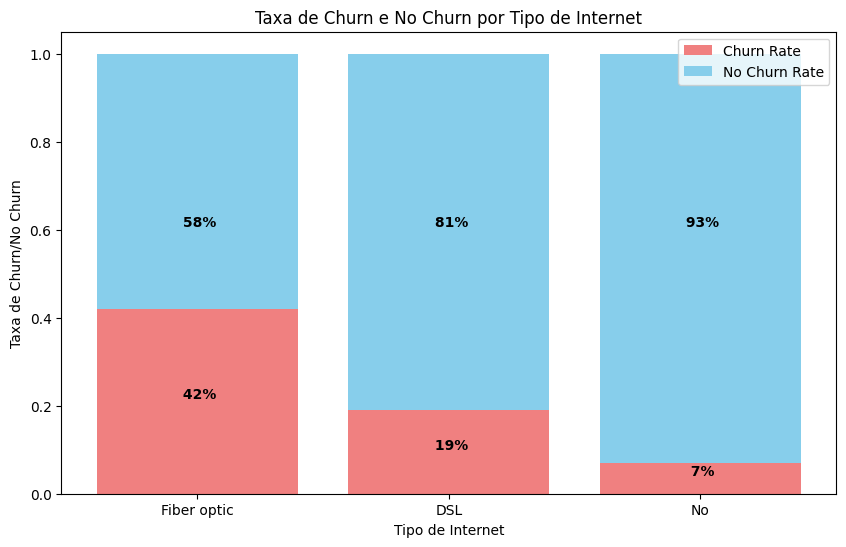

In [ ]:

labels_internet = resultados_internet['Internet Service']
churn_rate_internet = resultados_internet['Churn_Rate']
no_churn_rate_internet = resultados_internet['No_Churn_Rate']

fig, ax = plt.subplots(figsize=(10, 6))
bars_churn_internet = ax.bar(labels_internet, churn_rate_internet, label='Churn Rate', color='lightcoral')
bars_no_churn_internet = ax.bar(labels_internet, no_churn_rate_internet, bottom=churn_rate_internet, label='No Churn Rate', color='skyblue')

for bar_churn_internet, bar_no_churn_internet in zip(bars_churn_internet, bars_no_churn_internet):
    height_churn_internet = bar_churn_internet.get_height()
    height_no_churn_internet = bar_no_churn_internet.get_height()
    total_height_internet = height_churn_internet + height_no_churn_internet
    ax.text(bar_churn_internet.get_x() + bar_no_churn_internet.get_width() / 2, total_height_internet * 0.6, f'{height_no_churn_internet: .0%}',
            ha='center', va='bottom', color='black', fontweight='bold')

    ax.text(bar_no_churn_internet.get_x() + bar_churn_internet.get_width() / 2, height_churn_internet / 2, f'{height_churn_internet: .0%}',
            ha='center', va='bottom', color='black', fontweight='bold')

ax.set_ylabel('Taxa de Churn/No Churn')
ax.set_xlabel('Tipo de Internet')
ax.set_title('Taxa de Churn e No Churn por Tipo de Internet')
ax.legend()

plt.show()


####3.8 - Internet Service / Payment Method

In [ ]:
resultados_internet_payment_method = df_telco_customer_pd.groupby(['Internet Service', 'Payment Method'])['Churn Value'].agg(
    Total_Count='count',
    Churn_Count=lambda x: (x == 1).sum(),
    Churn_Rate=lambda x: (x == 1).mean()
).reset_index()


resultados_internet_payment_method['No_Churn_Count'] = resultados_internet_payment_method['Total_Count'] - resultados_internet_payment_method['Churn_Count']
resultados_internet_payment_method['No_Churn_Rate'] = 1 - resultados_internet_payment_method['Churn_Rate']


resultados_internet_payment_method = resultados_internet_payment_method[['Payment Method','Internet Service', 'Total_Count', 'Churn_Count', 'No_Churn_Count', 'Churn_Rate', 'No_Churn_Rate']]


resultados_internet_payment_method['Churn_Rate'] = resultados_internet_payment_method['Churn_Rate'].round(2)
resultados_internet_payment_method['No_Churn_Rate'] = resultados_internet_payment_method['No_Churn_Rate'].round(2)
resultados_internet_payment_method = resultados_internet_payment_method.sort_values(by='Churn_Rate', ascending=False)

resultados_internet_payment_method

,Payment Method,Internet Service,Total_Count,Churn_Count,No_Churn_Count,Churn_Rate,No_Churn_Rate
6,Electronic check,Fiber optic,1595,849,746,0.53,0.47
7,Mailed check,Fiber optic,258,110,148,0.43,0.57
2,Electronic check,DSL,648,207,441,0.32,0.68
4,Bank transfer (automatic),Fiber optic,646,187,459,0.29,0.71
5,Credit card (automatic),Fiber optic,597,151,446,0.25,0.75
3,Mailed check,DSL,613,127,486,0.21,0.79
1,Credit card (automatic),DSL,594,72,522,0.12,0.88
10,Electronic check,No,122,15,107,0.12,0.88
11,Mailed check,No,741,71,670,0.10,0.90
0,Bank transfer (automatic),DSL,566,53,513,0.09,0.91


<ipython-input-118-2ba0c2dbfe96>:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x='Payment Method', y='Total_Count', hue='Internet Service', data=resultados_internet_payment_method, palette=cores_personalizadas, ci=None)


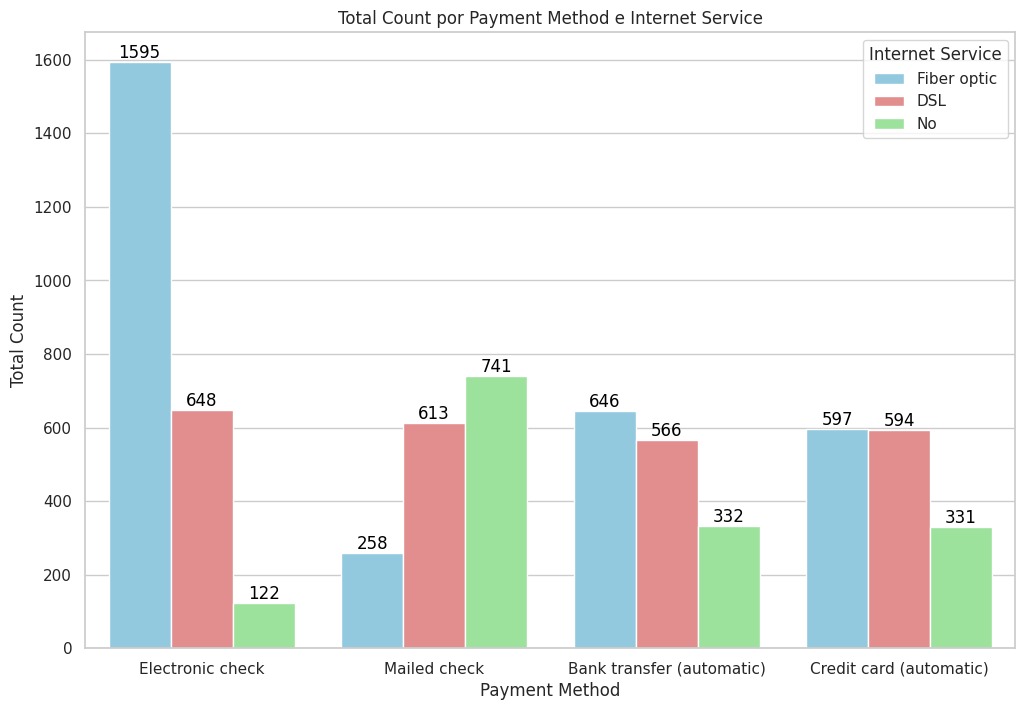

In [ ]:
sns.set(style="whitegrid")

# Especificar cores personalizadas
cores_personalizadas = ['skyblue', 'lightcoral', 'lightgreen']

# Criar o gráfico de barras agrupadas
plt.figure(figsize=(12, 8))
ax = sns.barplot(x='Payment Method', y='Total_Count', hue='Internet Service', data=resultados_internet_payment_method, palette=cores_personalizadas, ci=None)

# Adicionar os valores dentro de cada barra
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height + 0.2, f'{height:.0f}', ha='center', va='bottom', color='black', fontweight='normal')

# Adicionar rótulos e título
plt.xlabel('Payment Method')
plt.ylabel('Total Count')
plt.title('Total Count por Payment Method e Internet Service')

# Mostrar o gráfico
plt.show()


<ipython-input-121-0d097799f714>:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x='Payment Method', y='Churn_Rate', hue='Internet Service', data=resultados_internet_payment_method, palette=cores_personalizadas, ci=None)


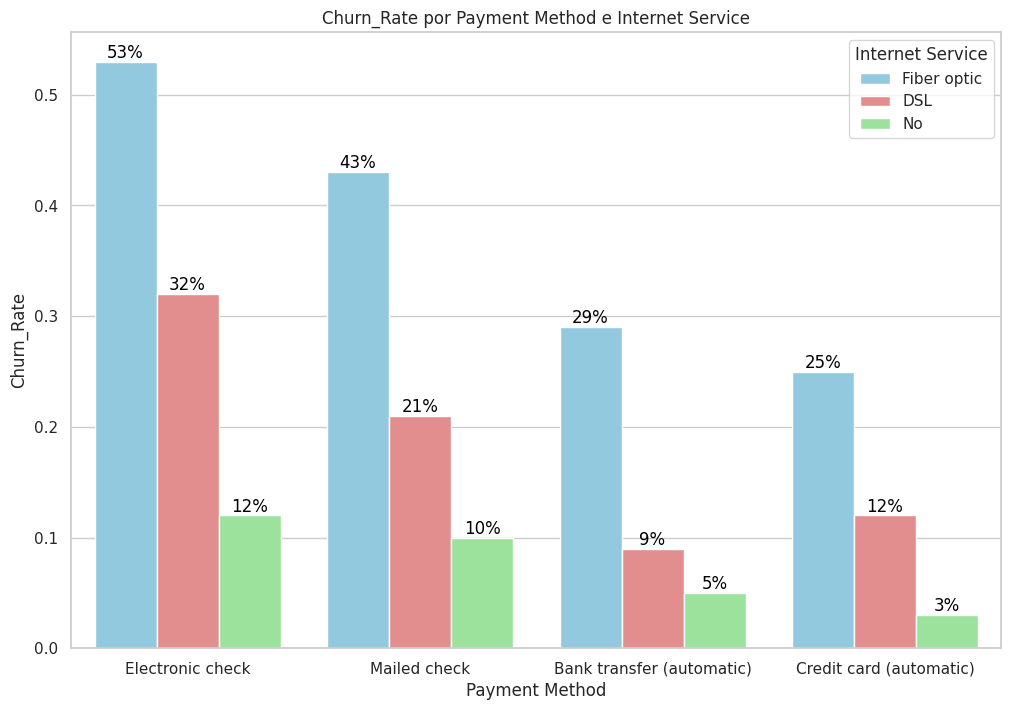

In [ ]:
sns.set(style="whitegrid")

# Especificar cores personalizadas
cores_personalizadas = ['skyblue', 'lightcoral', 'lightgreen']

# Criar o gráfico de barras agrupadas
plt.figure(figsize=(12, 8))
ax = sns.barplot(x='Payment Method', y='Churn_Rate', hue='Internet Service', data=resultados_internet_payment_method, palette=cores_personalizadas, ci=None)

# Adicionar os valores dentro de cada barra
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height, f'{height:.0%}', ha='center', va='bottom', color='black', fontweight='normal')

# Adicionar rótulos e título
plt.xlabel('Payment Method')
plt.ylabel('Churn_Rate')
plt.title('Churn_Rate por Payment Method e Internet Service')

# Mostrar o gráfico
plt.show()


## **4 - Processamento/tratamendo de dados para o modelo**

In [ ]:
df_telco_customer.show()

+---+---------------+------+--------------+-------+----------+-------------+-------------+----------------+----------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+-----------------+--------------------+---------------+-----------+-----------+
| id|           City|Gender|Senior Citizen|Partner|Dependents|Tenure Months|Phone Service|  Multiple Lines|Internet Service|    Online Security|      Online Backup|  Device Protection|       Tech Support|       Streaming TV|   Streaming Movies|      Contract|Paperless Billing|      Payment Method|Monthly Charges|Churn Label|Churn Value|
+---+---------------+------+--------------+-------+----------+-------------+-------------+----------------+----------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+-----------------+--------------------+---------------+--------

In [ ]:
mapeamento_colunas = {
    "Senior Citizen": "Senior_Citizen",
    "Tenure Months": "Tenure_Months",
    "Phone Service": "Phone_Service",
    "Multiple Lines": "Multiple_Lines",
    "Internet Service": "Internet_Service",
    "Online Security": "Online_Security",
    "Online Backup": "Online_Backup",
    "Device Protection": "Device_Protection",
    "Tech Support": "Tech_Support",
    "Streaming TV": "Streaming_TV",
    "Streaming Movies": "Streaming_Movies",
    "Paperless Billing": "Paperless_Billing",
    "Payment Method": "Payment_Method",
    "Monthly Charges": "Monthly_Charges",
    "Paperless Billing": "Paperless_Billing",
    "Churn Label": "Churn",
}

In [ ]:
df_telco_customer = df_telco_customer
for antigo, novo in mapeamento_colunas.items():
    df_telco_customer = df_telco_customer.withColumnRenamed(antigo, novo)

In [ ]:
df_telco_customer.show()

+---+---------------+------+--------------+-------+----------+-------------+-------------+----------------+----------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+-----------------+--------------------+---------------+-----+-----------+
| id|           City|Gender|Senior_Citizen|Partner|Dependents|Tenure_Months|Phone_Service|  Multiple_Lines|Internet_Service|    Online_Security|      Online_Backup|  Device_Protection|       Tech_Support|       Streaming_TV|   Streaming_Movies|      Contract|Paperless_Billing|      Payment_Method|Monthly_Charges|Churn|Churn Value|
+---+---------------+------+--------------+-------+----------+-------------+-------------+----------------+----------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+-----------------+--------------------+---------------+-----+-----------+
|

In [ ]:
colunasBinarias = [
    'Churn',
    'Senior_Citizen',
    'Partner',
    'Dependents',
    'Phone_Service',
    'Multiple_Lines',
    'Online_Security',
    'Online_Backup',
    'Device_Protection',
    'Tech_Support',
    'Streaming_TV',
    'Streaming_Movies',
    'Paperless_Billing'
]

In [ ]:
colunas = [f.when(f.col(c)=='Yes', 1).otherwise(0).alias(c) for c in colunasBinarias]

In [ ]:
for coluna in reversed(df_telco_customer.columns):
  if coluna not in colunasBinarias:
    colunas.insert(0, coluna)
colunas

['id',
 'City',
 'Gender',
 'Tenure_Months',
 'Internet_Service',
 'Contract',
 'Payment_Method',
 'Monthly_Charges',
 'Churn Value',
 Column<'CASE WHEN (Churn = Yes) THEN 1 ELSE 0 END AS Churn'>,
 Column<'CASE WHEN (Senior_Citizen = Yes) THEN 1 ELSE 0 END AS Senior_Citizen'>,
 Column<'CASE WHEN (Partner = Yes) THEN 1 ELSE 0 END AS Partner'>,
 Column<'CASE WHEN (Dependents = Yes) THEN 1 ELSE 0 END AS Dependents'>,
 Column<'CASE WHEN (Phone_Service = Yes) THEN 1 ELSE 0 END AS Phone_Service'>,
 Column<'CASE WHEN (Multiple_Lines = Yes) THEN 1 ELSE 0 END AS Multiple_Lines'>,
 Column<'CASE WHEN (Online_Security = Yes) THEN 1 ELSE 0 END AS Online_Security'>,
 Column<'CASE WHEN (Online_Backup = Yes) THEN 1 ELSE 0 END AS Online_Backup'>,
 Column<'CASE WHEN (Device_Protection = Yes) THEN 1 ELSE 0 END AS Device_Protection'>,
 Column<'CASE WHEN (Tech_Support = Yes) THEN 1 ELSE 0 END AS Tech_Support'>,
 Column<'CASE WHEN (Streaming_TV = Yes) THEN 1 ELSE 0 END AS Streaming_TV'>,
 Column<'CASE WHEN 

In [ ]:
df_telco_customer = df_telco_customer.select(colunas)

In [ ]:
df_telco_customer.select(['Internet_Service', 'Contract', 'Payment_Method']).show()

+----------------+--------------+--------------------+
|Internet_Service|      Contract|      Payment_Method|
+----------------+--------------+--------------------+
|             DSL|Month-to-month|        Mailed check|
|     Fiber optic|Month-to-month|    Electronic check|
|     Fiber optic|Month-to-month|    Electronic check|
|     Fiber optic|Month-to-month|    Electronic check|
|     Fiber optic|Month-to-month|Bank transfer (au...|
|             DSL|Month-to-month|Credit card (auto...|
|             DSL|Month-to-month|    Electronic check|
|              No|Month-to-month|        Mailed check|
|     Fiber optic|Month-to-month|    Electronic check|
|             DSL|Month-to-month|    Electronic check|
|             DSL|Month-to-month|        Mailed check|
|     Fiber optic|Month-to-month|    Electronic check|
|     Fiber optic|Month-to-month|    Electronic check|
|     Fiber optic|Month-to-month|Bank transfer (au...|
|     Fiber optic|Month-to-month|    Electronic check|
|     Fibe

In [ ]:
Internet_Service = df_telco_customer.groupBy('id').pivot('Internet_Service').agg(f.lit(1)).na.fill(0)
Contract = df_telco_customer.groupBy('id').pivot('Contract').agg(f.lit(1)).na.fill(0)
Payment_Method = df_telco_customer.groupBy('id').pivot('Payment_Method').agg(f.lit(1)).na.fill(0)

In [ ]:
df_telco_customer\
    .join(Internet_Service, 'id', how='inner')\
    .join(Contract, 'id', how='inner')\
    .join(Payment_Method, 'id', how='inner')\
    .select(
        '*',
        f.col('DSL').alias('DSL_Internet'),
        f.col('Fiber optic').alias('Fiber_optic_Internet'),
        f.col('No').alias('No_Internet'),
        f.col('Month-to-month').alias('Month_to_month_Contract'),
        f.col('One Year').alias('One_Year_Contract'),
        f.col('Two Year').alias('Two_Year_Contract'),
        f.col('Bank Transfer (automatic)').alias('Bank_Transfer_Automatic_Payment_Method'),
        f.col('Credit card (automatic)').alias('Credit_Card_Automatic_Payment_Method'),
        f.col('Electronic check').alias('Eletronic_Check_Payment_Method'),
        f.col('Mailed check').alias('Mailed_Check_Payment_Method')
    )\
    .drop(
        'City','Gender','Internet_Service', 'Contract', 'Payment_Method', 'DSL',
        'Fiber optic', 'No', 'Month-to-month', 'One Year', 'Two Year',
        'Bank Transfer (automatic)', 'Credit card (automatic)', 'Electronic check', 'Mailed check', 'Churn Value'
    )\
    .show()

+----+-------------+---------------+-----+--------------+-------+----------+-------------+--------------+---------------+-------------+-----------------+------------+------------+----------------+-----------------+------------+--------------------+-----------+-----------------------+-----------------+-----------------+--------------------------------------+------------------------------------+------------------------------+---------------------------+
|  id|Tenure_Months|Monthly_Charges|Churn|Senior_Citizen|Partner|Dependents|Phone_Service|Multiple_Lines|Online_Security|Online_Backup|Device_Protection|Tech_Support|Streaming_TV|Streaming_Movies|Paperless_Billing|DSL_Internet|Fiber_optic_Internet|No_Internet|Month_to_month_Contract|One_Year_Contract|Two_Year_Contract|Bank_Transfer_Automatic_Payment_Method|Credit_Card_Automatic_Payment_Method|Eletronic_Check_Payment_Method|Mailed_Check_Payment_Method|
+----+-------------+---------------+-----+--------------+-------+----------+------------

In [ ]:
df_telco_customer = df_telco_customer\
    .join(Internet_Service, 'id', how='inner')\
    .join(Contract, 'id', how='inner')\
    .join(Payment_Method, 'id', how='inner')\
    .select(
        '*',
        f.col('DSL').alias('DSL_Internet'),
        f.col('Fiber optic').alias('Fiber_optic_Internet'),
        f.col('No').alias('No_Internet'),
        f.col('Month-to-month').alias('Month_to_month_Contract'),
        f.col('One Year').alias('One_Year_Contract'),
        f.col('Two Year').alias('Two_Year_Contract'),
        f.col('Bank Transfer (automatic)').alias('Bank_Transfer_Automatic_Payment_Method'),
        f.col('Credit card (automatic)').alias('Credit_Card_Automatic_Payment_Method'),
        f.col('Electronic check').alias('Eletronic_Check_Payment_Method'),
        f.col('Mailed check').alias('Mailed_Check_Payment_Method')
    )\
    .drop(
        'City','Gender','Internet_Service', 'Contract', 'Payment_Method', 'DSL',
        'Fiber optic', 'No', 'Month-to-month', 'One Year', 'Two Year',
        'Bank Transfer (automatic)', 'Credit card (automatic)', 'Electronic check', 'Mailed check', 'Churn Value'
    )

In [ ]:
df_telco_customer.printSchema()

root
 |-- id: long (nullable = true)
 |-- Tenure_Months: long (nullable = true)
 |-- Monthly_Charges: string (nullable = true)
 |-- Churn: integer (nullable = false)
 |-- Senior_Citizen: integer (nullable = false)
 |-- Partner: integer (nullable = false)
 |-- Dependents: integer (nullable = false)
 |-- Phone_Service: integer (nullable = false)
 |-- Multiple_Lines: integer (nullable = false)
 |-- Online_Security: integer (nullable = false)
 |-- Online_Backup: integer (nullable = false)
 |-- Device_Protection: integer (nullable = false)
 |-- Tech_Support: integer (nullable = false)
 |-- Streaming_TV: integer (nullable = false)
 |-- Streaming_Movies: integer (nullable = false)
 |-- Paperless_Billing: integer (nullable = false)
 |-- DSL_Internet: integer (nullable = true)
 |-- Fiber_optic_Internet: integer (nullable = true)
 |-- No_Internet: integer (nullable = true)
 |-- Month_to_month_Contract: integer (nullable = true)
 |-- One_Year_Contract: integer (nullable = true)
 |-- Two_Year_Cont

In [ ]:
df_telco_customer = df_telco_customer.withColumn("Monthly_Charges", f.regexp_replace(f.col("Monthly_Charges"), ",", "."))

In [ ]:
df_telco_customer = df_telco_customer.withColumn("Monthly_Charges", f.col("Monthly_Charges").cast("double"))

In [ ]:
df_telco_customer.show()

+----+-------------+---------------+-----+--------------+-------+----------+-------------+--------------+---------------+-------------+-----------------+------------+------------+----------------+-----------------+------------+--------------------+-----------+-----------------------+-----------------+-----------------+--------------------------------------+------------------------------------+------------------------------+---------------------------+
|  id|Tenure_Months|Monthly_Charges|Churn|Senior_Citizen|Partner|Dependents|Phone_Service|Multiple_Lines|Online_Security|Online_Backup|Device_Protection|Tech_Support|Streaming_TV|Streaming_Movies|Paperless_Billing|DSL_Internet|Fiber_optic_Internet|No_Internet|Month_to_month_Contract|One_Year_Contract|Two_Year_Contract|Bank_Transfer_Automatic_Payment_Method|Credit_Card_Automatic_Payment_Method|Eletronic_Check_Payment_Method|Mailed_Check_Payment_Method|
+----+-------------+---------------+-----+--------------+-------+----------+------------

In [ ]:
df_telco_customer = df_telco_customer.withColumnRenamed('Churn', 'label')

In [ ]:
X = df_telco_customer.columns
X.remove('label')
X.remove('id')
X

['Tenure_Months',
 'Monthly_Charges',
 'Senior_Citizen',
 'Partner',
 'Dependents',
 'Phone_Service',
 'Multiple_Lines',
 'Online_Security',
 'Online_Backup',
 'Device_Protection',
 'Tech_Support',
 'Streaming_TV',
 'Streaming_Movies',
 'Paperless_Billing',
 'DSL_Internet',
 'Fiber_optic_Internet',
 'No_Internet',
 'Month_to_month_Contract',
 'One_Year_Contract',
 'Two_Year_Contract',
 'Bank_Transfer_Automatic_Payment_Method',
 'Credit_Card_Automatic_Payment_Method',
 'Eletronic_Check_Payment_Method',
 'Mailed_Check_Payment_Method']

In [ ]:
assembler = VectorAssembler(inputCols=X, outputCol='features')

In [ ]:
df_telco_customer_prep = assembler.transform(df_telco_customer).select('features', 'label')

In [ ]:
df_telco_customer_prep.show(10, truncate=False)

+------------------------------------------------------------------------------------------------+-----+
|features                                                                                        |label|
+------------------------------------------------------------------------------------------------+-----+
|(24,[0,1,5,6,12,13,15,17,22],[7.0,86.8,1.0,1.0,1.0,1.0,1.0,1.0,1.0])                            |1    |
|(24,[0,1,5,13,15,17,23],[6.0,69.25,1.0,1.0,1.0,1.0,1.0])                                        |1    |
|(24,[0,1,5,6,8,10,11,12,13,15,17,20],[56.0,105.45,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])     |0    |
|(24,[0,1,5,16,18,23],[38.0,20.05,1.0,1.0,1.0,1.0])                                              |0    |
|(24,[0,1,3,5,6,7,8,11,12,13,15,18,22],[72.0,104.15,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])|0    |
|(24,[0,1,3,4,5,8,9,11,13,15,17,22],[58.0,91.55,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])        |0    |
|(24,[0,1,3,5,16,17,23],[2.0,20.0,1.0,1.0,1.0,1.0,1.0])

#

## **5 - O Modelo**

####5.1 - Logistic Regression

In [ ]:
SEED = 101

In [ ]:
treino, teste = df_telco_customer_prep.randomSplit([0.7, 0.3], seed=SEED)

In [ ]:
treino.count()

4933

In [ ]:
teste.count()

2110

In [ ]:
lr = LogisticRegression()

In [ ]:
modelo_lr = lr.fit(treino)

In [ ]:
previsoes_lr_treino = modelo_lr.transform(treino)

In [ ]:
previsoes_lr_treino.show()

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|(24,[0,1,2,3,4,5,...|    0|[3.98932155894434...|[0.98182420585288...|       0.0|
|(24,[0,1,2,3,4,5,...|    0|[4.54074189490850...|[0.98944706132766...|       0.0|
|(24,[0,1,2,3,4,5,...|    0|[2.23771520734126...|[0.90358559365632...|       0.0|
|(24,[0,1,2,3,4,5,...|    0|[2.89983587923312...|[0.94783832324999...|       0.0|
|(24,[0,1,2,3,4,5,...|    0|[2.63382316221721...|[0.93300691218296...|       0.0|
|(24,[0,1,2,3,4,5,...|    0|[2.45019294192513...|[0.92057555914102...|       0.0|
|(24,[0,1,2,3,4,5,...|    0|[2.44258682908855...|[0.92001764704036...|       0.0|
|(24,[0,1,2,3,4,5,...|    0|[0.61305853089605...|[0.64863817823310...|       0.0|
|(24,[0,1,2,3,4,5,...|    0|[1.21869920596758...|[0.77183455282993...|       0.0|
|(24,[0,1,2,3,4,

In [ ]:
previsoes_lr_teste = modelo_lr.transform(teste)

In [ ]:
previsoes_lr_teste.show()

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|(24,[0,1,2,3,4,5,...|    0|[4.38788377844788...|[0.98772553507378...|       0.0|
|(24,[0,1,2,3,4,5,...|    0|[1.24839175694337...|[0.77702134245321...|       0.0|
|(24,[0,1,2,3,4,5,...|    0|[3.31839913848362...|[0.96505464390407...|       0.0|
|(24,[0,1,2,3,4,5,...|    0|[1.14907624045026...|[0.75934214804849...|       0.0|
|(24,[0,1,2,3,4,5,...|    0|[-0.1128200273567...|[0.47182487208380...|       1.0|
|(24,[0,1,2,3,4,5,...|    0|[2.50010352227022...|[0.92414907695599...|       0.0|
|(24,[0,1,2,3,4,5,...|    1|[1.37683146730308...|[0.79848163788978...|       0.0|
|(24,[0,1,2,3,4,5,...|    0|[5.46487055994682...|[0.99578495290917...|       0.0|
|(24,[0,1,2,3,4,5,...|    1|[1.87974620407581...|[0.86758197221545...|       0.0|
|(24,[0,1,2,3,4,

In [ ]:
evaluator = MulticlassClassificationEvaluator()

In [ ]:
def calcular_matriz_confusao(df_transform_modelo, normalize=False):
    tp = df_transform_modelo.filter((f.col('label') == 1) & (f.col('prediction') == 1)).count()
    tn = df_transform_modelo.filter((f.col('label') == 0) & (f.col('prediction') == 0)).count()
    fp = df_transform_modelo.filter((f.col('label') == 0) & (f.col('prediction') == 1)).count()
    fn = df_transform_modelo.filter((f.col('label') == 1) & (f.col('prediction') == 0)).count()

    valor_p = 1
    valor_n = 1

    if normalize:
        valor_p = tp + fn
        valor_n = fp + tn

    return tp, tn, fp, fn, valor_p, valor_n

def mostrar_matriz_confusao(tp, tn, fp, fn, valor_p, valor_n):
    print(' ' * 20, 'Previsto')
    print(' ' * 15, 'Churn', ' ' * 5, 'Não-Churn')
    print(' ' * 4, 'Churn', ' ' * 6, int(tp / valor_p), ' ' * 7, int(fn / valor_p))
    print('Real')
    print(' ' * 4, 'Não-Churn', ' ' * 2, int(fp / valor_n), ' ' * 7, int(tn / valor_n))

def calcular_e_mostrar_metricas(df, evaluator, name):
    print(f"{name}")
    print("=" * 40)

    print("Matriz de Confusão")
    print("-" * 40)
    tp, tn, fp, fn, valor_p, valor_n = calcular_matriz_confusao(df, normalize=False)
    mostrar_matriz_confusao(tp, tn, fp, fn, valor_p, valor_n)
    print("-" * 40)

    print("Métricas")
    print("-" * 40)
    print("Acurácia: %f" % evaluator.evaluate(df, {evaluator.metricName: "accuracy"}))
    print("Precisão: %f" % evaluator.evaluate(df, {evaluator.metricName: "precisionByLabel", evaluator.metricLabel: 1}))
    print("Recall: %f" % evaluator.evaluate(df, {evaluator.metricName: "recallByLabel", evaluator.metricLabel: 1}))
    print("F1: %f" % evaluator.evaluate(df, {evaluator.metricName: "fMeasureByLabel", evaluator.metricLabel: 1}))
    print("")

In [ ]:
calcular_e_mostrar_metricas(previsoes_lr_teste, evaluator, "Logistic Regression - Classificação - Dados de Teste")

Logistic Regression - Classificação - Dados de Teste
Matriz de Confusão
----------------------------------------
                     Previsto
                Churn       Não-Churn
     Churn        304         239
Real
     Não-Churn    157         1410
----------------------------------------
Métricas
----------------------------------------
Acurácia: 0.812322
Precisão: 0.659436
Recall: 0.559853
F1: 0.605578



####5.2 - Decision Tree

In [ ]:
dtc = DecisionTreeClassifier(seed=SEED)

In [ ]:
modelo_dtc = dtc.fit(treino)

In [ ]:
previsoes_dtc_treino = modelo_dtc.transform(treino)

In [ ]:
previsoes_dtc_treino.show()

+--------------------+-----+--------------+--------------------+----------+
|            features|label| rawPrediction|         probability|prediction|
+--------------------+-----+--------------+--------------------+----------+
|(24,[0,1,2,3,4,5,...|    0|[2049.0,144.0]|[0.93433652530779...|       0.0|
|(24,[0,1,2,3,4,5,...|    0|[2049.0,144.0]|[0.93433652530779...|       0.0|
|(24,[0,1,2,3,4,5,...|    0| [479.0,329.0]|[0.59282178217821...|       0.0|
|(24,[0,1,2,3,4,5,...|    0| [479.0,329.0]|[0.59282178217821...|       0.0|
|(24,[0,1,2,3,4,5,...|    0| [479.0,329.0]|[0.59282178217821...|       0.0|
|(24,[0,1,2,3,4,5,...|    0| [479.0,329.0]|[0.59282178217821...|       0.0|
|(24,[0,1,2,3,4,5,...|    0| [479.0,329.0]|[0.59282178217821...|       0.0|
|(24,[0,1,2,3,4,5,...|    0| [479.0,329.0]|[0.59282178217821...|       0.0|
|(24,[0,1,2,3,4,5,...|    0| [479.0,329.0]|[0.59282178217821...|       0.0|
|(24,[0,1,2,3,4,5,...|    0|[2049.0,144.0]|[0.93433652530779...|       0.0|
|(24,[0,1,2,

In [ ]:
previsoes_dtc_teste = modelo_dtc.transform(teste)

In [ ]:
previsoes_dtc_teste.show()

+--------------------+-----+--------------+--------------------+----------+
|            features|label| rawPrediction|         probability|prediction|
+--------------------+-----+--------------+--------------------+----------+
|(24,[0,1,2,3,4,5,...|    0|[2049.0,144.0]|[0.93433652530779...|       0.0|
|(24,[0,1,2,3,4,5,...|    0| [479.0,329.0]|[0.59282178217821...|       0.0|
|(24,[0,1,2,3,4,5,...|    0|[2049.0,144.0]|[0.93433652530779...|       0.0|
|(24,[0,1,2,3,4,5,...|    0| [479.0,329.0]|[0.59282178217821...|       0.0|
|(24,[0,1,2,3,4,5,...|    0| [198.0,349.0]|[0.36197440585009...|       1.0|
|(24,[0,1,2,3,4,5,...|    0|[2049.0,144.0]|[0.93433652530779...|       0.0|
|(24,[0,1,2,3,4,5,...|    1| [479.0,329.0]|[0.59282178217821...|       0.0|
|(24,[0,1,2,3,4,5,...|    0|[2049.0,144.0]|[0.93433652530779...|       0.0|
|(24,[0,1,2,3,4,5,...|    1| [112.0,139.0]|[0.44621513944223...|       1.0|
|(24,[0,1,2,3,4,5,...|    1| [641.0,165.0]|[0.79528535980148...|       0.0|
|(24,[0,1,2,

In [ ]:
calcular_e_mostrar_metricas(previsoes_dtc_teste, evaluator, "Decision Tree - Classificação - Dados de Teste")

Decision Tree - Classificação - Dados de Teste
Matriz de Confusão
----------------------------------------
                     Previsto
                Churn       Não-Churn
     Churn        247         296
Real
     Não-Churn    132         1435
----------------------------------------
Métricas
----------------------------------------
Acurácia: 0.797156
Precisão: 0.651715
Recall: 0.454880
F1: 0.535792



####5.3 - Random Forest

In [ ]:
rfc = RandomForestClassifier(seed=SEED)

In [ ]:
modelo_rfc = rfc.fit(treino)

In [ ]:
previsoes_rfc_treino = modelo_rfc.transform(treino)

In [ ]:
previsoes_rfc_treino.show()

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|(24,[0,1,2,3,4,5,...|    0|[16.5537499148215...|[0.82768749574107...|       0.0|
|(24,[0,1,2,3,4,5,...|    0|[17.2253865305002...|[0.86126932652501...|       0.0|
|(24,[0,1,2,3,4,5,...|    0|[14.7644725722485...|[0.73822362861242...|       0.0|
|(24,[0,1,2,3,4,5,...|    0|[14.4889273752075...|[0.72444636876037...|       0.0|
|(24,[0,1,2,3,4,5,...|    0|[14.4889273752075...|[0.72444636876037...|       0.0|
|(24,[0,1,2,3,4,5,...|    0|[14.2902278934322...|[0.71451139467161...|       0.0|
|(24,[0,1,2,3,4,5,...|    0|[13.7252706999949...|[0.68626353499974...|       0.0|
|(24,[0,1,2,3,4,5,...|    0|[13.8731448519949...|[0.69365724259974...|       0.0|
|(24,[0,1,2,3,4,5,...|    0|[14.3600700421280...|[0.71800350210640...|       0.0|
|(24,[0,1,2,3,4,

In [ ]:
previsoes_rfc_teste = modelo_rfc.transform(teste)

In [ ]:
previsoes_rfc_teste.show()

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|(24,[0,1,2,3,4,5,...|    0|[16.6229511797121...|[0.83114755898560...|       0.0|
|(24,[0,1,2,3,4,5,...|    0|[14.1565087916566...|[0.70782543958283...|       0.0|
|(24,[0,1,2,3,4,5,...|    0|[16.9816032755346...|[0.84908016377673...|       0.0|
|(24,[0,1,2,3,4,5,...|    0|[14.1547106520529...|[0.70773553260264...|       0.0|
|(24,[0,1,2,3,4,5,...|    0|[11.9423881215163...|[0.59711940607581...|       0.0|
|(24,[0,1,2,3,4,5,...|    0|[16.9816032755346...|[0.84908016377673...|       0.0|
|(24,[0,1,2,3,4,5,...|    1|[13.3331069013308...|[0.66665534506654...|       0.0|
|(24,[0,1,2,3,4,5,...|    0|[18.4196659814633...|[0.92098329907316...|       0.0|
|(24,[0,1,2,3,4,5,...|    1|[14.1688467057517...|[0.70844233528758...|       0.0|
|(24,[0,1,2,3,4,

In [ ]:
calcular_e_mostrar_metricas(previsoes_rfc_teste, evaluator, "Random Forest - Classificação - Dados de Teste")

Random Forest - Classificação - Dados de Teste
Matriz de Confusão
----------------------------------------
                     Previsto
                Churn       Não-Churn
     Churn        191         352
Real
     Não-Churn    66         1501
----------------------------------------
Métricas
----------------------------------------
Acurácia: 0.801896
Precisão: 0.743191
Recall: 0.351750
F1: 0.477500



####5.4 - Comparação Entre Modelos

In [ ]:
calcular_e_mostrar_metricas(previsoes_lr_teste, evaluator, "Logistic Regression - Classificação - Dados de Teste")
calcular_e_mostrar_metricas(previsoes_dtc_teste, evaluator, "Decision Tree - Classificação - Dados de Teste")
calcular_e_mostrar_metricas(previsoes_rfc_teste, evaluator, "Random Forest - Classificação - Dados de Teste")

Logistic Regression - Classificação - Dados de Teste
Matriz de Confusão
----------------------------------------
                     Previsto
                Churn       Não-Churn
     Churn        304         239
Real
     Não-Churn    157         1410
----------------------------------------
Métricas
----------------------------------------
Acurácia: 0.812322
Precisão: 0.659436
Recall: 0.559853
F1: 0.605578

Decision Tree - Classificação - Dados de Teste
Matriz de Confusão
----------------------------------------
                     Previsto
                Churn       Não-Churn
     Churn        247         296
Real
     Não-Churn    132         1435
----------------------------------------
Métricas
----------------------------------------
Acurácia: 0.797156
Precisão: 0.651715
Recall: 0.454880
F1: 0.535792

Random Forest - Classificação - Dados de Teste
Matriz de Confusão
----------------------------------------
                     Previsto
                Churn       Não-Churn
 

## **6 - Cross Validation**

####6.1 - Logistic Regression

In [ ]:
grid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .addGrid(lr.elasticNetParam, [0.0, 1.0])\
    .build()

In [ ]:
lr_cv = CrossValidator(
    estimator=lr,
    estimatorParamMaps=grid,
    evaluator=evaluator,
    numFolds=3,
    seed=SEED
)

In [ ]:
modelo_lr_cv = lr_cv.fit(treino)

In [ ]:
previsoes_lr_cv_treino = modelo_lr_cv.transform(treino)

In [ ]:
previsoes_lr_cv_treino.show()

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|(24,[0,1,2,3,4,5,...|    0|[3.70880859835361...|[0.97607950915752...|       0.0|
|(24,[0,1,2,3,4,5,...|    0|[4.16896782137127...|[0.98476740327382...|       0.0|
|(24,[0,1,2,3,4,5,...|    0|[2.01025685055531...|[0.88186978234246...|       0.0|
|(24,[0,1,2,3,4,5,...|    0|[2.42263411974844...|[0.91853706452067...|       0.0|
|(24,[0,1,2,3,4,5,...|    0|[2.14053861758083...|[0.89478133086809...|       0.0|
|(24,[0,1,2,3,4,5,...|    0|[2.07684521488388...|[0.88863220252344...|       0.0|
|(24,[0,1,2,3,4,5,...|    0|[2.06798699131160...|[0.88775252571353...|       0.0|
|(24,[0,1,2,3,4,5,...|    0|[0.46045459097512...|[0.61312201221248...|       0.0|
|(24,[0,1,2,3,4,5,...|    0|[0.96033322709205...|[0.72318851777909...|       0.0|
|(24,[0,1,2,3,4,

In [ ]:
previsoes_lr_cv_teste = modelo_lr_cv.transform(teste)

In [ ]:
previsoes_lr_cv_teste.show()

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|(24,[0,1,2,3,4,5,...|    0|[3.94351018671286...|[0.98098837894532...|       0.0|
|(24,[0,1,2,3,4,5,...|    0|[1.06657952212202...|[0.74394589147831...|       0.0|
|(24,[0,1,2,3,4,5,...|    0|[2.95996777301383...|[0.95073248441853...|       0.0|
|(24,[0,1,2,3,4,5,...|    0|[0.90109875936910...|[0.71117524566699...|       0.0|
|(24,[0,1,2,3,4,5,...|    0|[-0.2122602862493...|[0.44713326957966...|       1.0|
|(24,[0,1,2,3,4,5,...|    0|[2.24406450726567...|[0.90413732056625...|       0.0|
|(24,[0,1,2,3,4,5,...|    1|[1.01197390757411...|[0.73340626840436...|       0.0|
|(24,[0,1,2,3,4,5,...|    0|[4.94617135211274...|[0.99293962259372...|       0.0|
|(24,[0,1,2,3,4,5,...|    1|[1.80407713577258...|[0.85864451780018...|       0.0|
|(24,[0,1,2,3,4,

In [ ]:
calcular_e_mostrar_metricas(previsoes_lr_cv_teste, evaluator, "Logistic Regression - Cross Validator - Dados de Teste")

Logistic Regression - Cross Validator - Dados de Teste
Matriz de Confusão
----------------------------------------
                     Previsto
                Churn       Não-Churn
     Churn        303         240
Real
     Não-Churn    151         1416
----------------------------------------
Métricas
----------------------------------------
Acurácia: 0.814692
Precisão: 0.667401
Recall: 0.558011
F1: 0.607823



####6.2 - Decision Tree

In [ ]:
grid = ParamGridBuilder()\
        .addGrid(dtc.maxDepth, [2, 5, 10])\
        .addGrid(dtc.maxBins, [10, 32, 45])\
        .build()

In [ ]:
dtc_cv = CrossValidator(
    estimator=dtc,
    estimatorParamMaps=grid,
    evaluator=evaluator,
    numFolds=3,
    seed=SEED
)

In [ ]:
modelo_dtc_cv = dtc_cv.fit(treino)

In [ ]:
previsoes_dtc_cv_treino = modelo_dtc_cv.transform(treino)

In [ ]:
previsoes_dtc_cv_treino.show()

+--------------------+-----+--------------+--------------------+----------+
|            features|label| rawPrediction|         probability|prediction|
+--------------------+-----+--------------+--------------------+----------+
|(24,[0,1,2,3,4,5,...|    0|[2049.0,144.0]|[0.93433652530779...|       0.0|
|(24,[0,1,2,3,4,5,...|    0|[2049.0,144.0]|[0.93433652530779...|       0.0|
|(24,[0,1,2,3,4,5,...|    0|  [106.0,10.0]|[0.91379310344827...|       0.0|
|(24,[0,1,2,3,4,5,...|    0|  [106.0,10.0]|[0.91379310344827...|       0.0|
|(24,[0,1,2,3,4,5,...|    0|  [106.0,10.0]|[0.91379310344827...|       0.0|
|(24,[0,1,2,3,4,5,...|    0|  [106.0,10.0]|[0.91379310344827...|       0.0|
|(24,[0,1,2,3,4,5,...|    0|  [106.0,10.0]|[0.91379310344827...|       0.0|
|(24,[0,1,2,3,4,5,...|    0|  [106.0,10.0]|[0.91379310344827...|       0.0|
|(24,[0,1,2,3,4,5,...|    0|  [106.0,10.0]|[0.91379310344827...|       0.0|
|(24,[0,1,2,3,4,5,...|    0|[2049.0,144.0]|[0.93433652530779...|       0.0|
|(24,[0,1,2,

In [ ]:
previsoes_dtc_cv_teste = modelo_dtc_cv.transform(teste)

In [ ]:
previsoes_dtc_cv_teste.show()

+--------------------+-----+--------------+--------------------+----------+
|            features|label| rawPrediction|         probability|prediction|
+--------------------+-----+--------------+--------------------+----------+
|(24,[0,1,2,3,4,5,...|    0|[2049.0,144.0]|[0.93433652530779...|       0.0|
|(24,[0,1,2,3,4,5,...|    0|  [106.0,10.0]|[0.91379310344827...|       0.0|
|(24,[0,1,2,3,4,5,...|    0|[2049.0,144.0]|[0.93433652530779...|       0.0|
|(24,[0,1,2,3,4,5,...|    0|  [106.0,10.0]|[0.91379310344827...|       0.0|
|(24,[0,1,2,3,4,5,...|    0|  [106.0,10.0]|[0.91379310344827...|       0.0|
|(24,[0,1,2,3,4,5,...|    0|[2049.0,144.0]|[0.93433652530779...|       0.0|
|(24,[0,1,2,3,4,5,...|    1|  [106.0,10.0]|[0.91379310344827...|       0.0|
|(24,[0,1,2,3,4,5,...|    0|[2049.0,144.0]|[0.93433652530779...|       0.0|
|(24,[0,1,2,3,4,5,...|    1| [112.0,139.0]|[0.44621513944223...|       1.0|
|(24,[0,1,2,3,4,5,...|    1| [641.0,165.0]|[0.79528535980148...|       0.0|
|(24,[0,1,2,

In [ ]:
calcular_e_mostrar_metricas(previsoes_dtc_cv_teste, evaluator, "Decision Tree - Cross Validator - Dados de Teste")

Decision Tree - Cross Validator - Dados de Teste
Matriz de Confusão
----------------------------------------
                     Previsto
                Churn       Não-Churn
     Churn        372         171
Real
     Não-Churn    257         1310
----------------------------------------
Métricas
----------------------------------------
Acurácia: 0.797156
Precisão: 0.591415
Recall: 0.685083
F1: 0.634812



####6.3 - Random Forest

In [ ]:
grid = ParamGridBuilder()\
        .addGrid(rfc.maxDepth, [2, 5, 10])\
        .addGrid(rfc.maxBins, [10, 32, 45])\
        .addGrid(rfc.numTrees, [10, 20, 50])\
        .build()

In [ ]:
rfc_cv = CrossValidator(
    estimator=rfc,
    estimatorParamMaps=grid,
    evaluator=evaluator,
    numFolds=3,
    seed=SEED
)

In [ ]:
modelo_rfc_cv = rfc_cv.fit(treino)

In [ ]:
previsoes_rfc_cv_treino = modelo_rfc_cv.transform(treino)

In [ ]:
previsoes_rfc_cv_treino.show()

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|(24,[0,1,2,3,4,5,...|    0|[49.3310596390511...|[0.98662119278102...|       0.0|
|(24,[0,1,2,3,4,5,...|    0|[49.0624112046916...|[0.98124822409383...|       0.0|
|(24,[0,1,2,3,4,5,...|    0|[46.3208984843093...|[0.92641796968618...|       0.0|
|(24,[0,1,2,3,4,5,...|    0|[44.7583402238563...|[0.89516680447712...|       0.0|
|(24,[0,1,2,3,4,5,...|    0|[44.8518217498639...|[0.89703643499727...|       0.0|
|(24,[0,1,2,3,4,5,...|    0|[44.9546113318160...|[0.89909222663632...|       0.0|
|(24,[0,1,2,3,4,5,...|    0|[44.1870173705582...|[0.88374034741116...|       0.0|
|(24,[0,1,2,3,4,5,...|    0|[42.1889068103646...|[0.84377813620729...|       0.0|
|(24,[0,1,2,3,4,5,...|    0|[43.7603548068126...|[0.87520709613625...|       0.0|
|(24,[0,1,2,3,4,

In [ ]:
previsoes_rfc_cv_teste = modelo_rfc_cv.transform(teste)

In [ ]:
previsoes_rfc_cv_teste.show()

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|(24,[0,1,2,3,4,5,...|    0|[46.1187011729974...|[0.92237402345994...|       0.0|
|(24,[0,1,2,3,4,5,...|    0|[33.9143647949554...|[0.67828729589910...|       0.0|
|(24,[0,1,2,3,4,5,...|    0|[42.3345657356742...|[0.84669131471348...|       0.0|
|(24,[0,1,2,3,4,5,...|    0|[44.2666867509088...|[0.88533373501817...|       0.0|
|(24,[0,1,2,3,4,5,...|    0|[30.0119816655229...|[0.60023963331045...|       0.0|
|(24,[0,1,2,3,4,5,...|    0|[45.3452529136484...|[0.90690505827296...|       0.0|
|(24,[0,1,2,3,4,5,...|    1|[37.1262424872318...|[0.74252484974463...|       0.0|
|(24,[0,1,2,3,4,5,...|    0|[49.8525009198480...|[0.99705001839696...|       0.0|
|(24,[0,1,2,3,4,5,...|    1|[29.1292784428995...|[0.58258556885799...|       0.0|
|(24,[0,1,2,3,4,

In [ ]:
calcular_e_mostrar_metricas(previsoes_rfc_cv_teste, evaluator, "Random Forest - Cross Validator - Dados de Teste")

Random Forest - Cross Validator - Dados de Teste
Matriz de Confusão
----------------------------------------
                     Previsto
                Churn       Não-Churn
     Churn        291         252
Real
     Não-Churn    150         1417
----------------------------------------
Métricas
----------------------------------------
Acurácia: 0.809479
Precisão: 0.659864
Recall: 0.535912
F1: 0.591463



####6.4 - Comparação Entre Modelos Após o Tuning

In [ ]:
calcular_e_mostrar_metricas(previsoes_lr_cv_teste, evaluator, "Logistic Regression - Cross Validator - Dados de Teste")
calcular_e_mostrar_metricas(previsoes_dtc_cv_teste, evaluator, "Decision Tree - Cross Validator - Dados de Teste")
calcular_e_mostrar_metricas(previsoes_rfc_cv_teste, evaluator, "Random Forest - Cross Validator - Dados de Teste")

Logistic Regression - Cross Validator - Dados de Teste
Matriz de Confusão
----------------------------------------
                     Previsto
                Churn       Não-Churn
     Churn        303         240
Real
     Não-Churn    151         1416
----------------------------------------
Métricas
----------------------------------------
Acurácia: 0.814692
Precisão: 0.667401
Recall: 0.558011
F1: 0.607823

Decision Tree - Cross Validator - Dados de Teste
Matriz de Confusão
----------------------------------------
                     Previsto
                Churn       Não-Churn
     Churn        372         171
Real
     Não-Churn    257         1310
----------------------------------------
Métricas
----------------------------------------
Acurácia: 0.797156
Precisão: 0.591415
Recall: 0.685083
F1: 0.634812

Random Forest - Cross Validator - Dados de Teste
Matriz de Confusão
----------------------------------------
                     Previsto
                Churn       Não-C

## **7 - Refinamento do Modelo Escolhido**

In [ ]:
total_churn = treino.filter("label == 1").count()
total_no_churn = treino.filter("label == 0").count()

In [ ]:
treino.count()

4933

In [ ]:
total_churn

1326

In [ ]:
total_no_churn

3607

In [ ]:
weight_churn = total_no_churn / total_churn
weight_no_churn = 1.0

In [ ]:
treino = treino.withColumn("weight", f.when(treino["label"] == 1, weight_churn).otherwise(weight_no_churn))

In [ ]:
rfc_weights = RandomForestClassifier(seed=SEED, weightCol="weight")

In [ ]:
grid = ParamGridBuilder()\
        .addGrid(rfc_weights.maxDepth, [2, 5, 10])\
        .addGrid(rfc_weights.maxBins, [10, 32, 45])\
        .addGrid(rfc_weights.numTrees, [10, 20, 50])\
        .build()

In [ ]:
rfc_cv_weights = CrossValidator(
    estimator=rfc_weights,
    estimatorParamMaps=grid,
    evaluator=evaluator,
    numFolds=3,
    seed=SEED)

In [ ]:
modelo_rfc_cv_weights = rfc_cv_weights.fit(treino)

In [ ]:
previsoes_rfc_cv_weights_teste = modelo_rfc_cv_weights.transform(teste)

In [ ]:
calcular_e_mostrar_metricas(previsoes_rfc_cv_weights_teste, evaluator, "Random Forest Weights - Cross Validator - Dados de Teste")

Random Forest Weights - Cross Validator - Dados de Teste
Matriz de Confusão
----------------------------------------
                     Previsto
                Churn       Não-Churn
     Churn        396         147
Real
     Não-Churn    323         1244
----------------------------------------
Métricas
----------------------------------------
Acurácia: 0.777251
Precisão: 0.550765
Recall: 0.729282
F1: 0.627575



## **8 - Cadastro e Teste Para Novos Clientes**

In [ ]:
novo_cliente = [{
'Tenure_Months': 1,
 'Monthly_Charges': 37.5603476145074,
 'Senior_Citizen': 0,
 'Partner': 0,
 'Dependents': 1,
 'Phone_Service': 0,
 'Multiple_Lines': 0,
 'Online_Security': 0,
 'Online_Backup': 0,
 'Device_Protection': 0,
 'Tech_Support': 0,
 'Streaming_TV': 0,
 'Streaming_Movies': 0,
 'Paperless_Billing': 1,
 'DSL_Internet': 0,
 'Fiber_optic_Internet': 1,
 'No_Internet': 0,
 'Month_to_month_Contract': 1,
 'One_Year_Contract': 0,
 'Two_Year_Contract': 0,
 'Bank_Transfer_Automatic_Payment_Method': 0,
 'Credit_Card_Automatic_Payment_Method': 0,
 'Eletronic_Check_Payment_Method': 1,
 'Mailed_Check_Payment_Method': 0
 }]

In [ ]:
novo_cliente = spark.createDataFrame(novo_cliente)
novo_cliente.show()

+--------------------------------------+------------------------------------+------------+----------+-----------------+------------------------------+--------------------+---------------------------+-----------------------+----------------+--------------+-----------+-----------------+-------------+---------------+-----------------+-------+-------------+--------------+----------------+------------+------------+-------------+-----------------+
|Bank_Transfer_Automatic_Payment_Method|Credit_Card_Automatic_Payment_Method|DSL_Internet|Dependents|Device_Protection|Eletronic_Check_Payment_Method|Fiber_optic_Internet|Mailed_Check_Payment_Method|Month_to_month_Contract| Monthly_Charges|Multiple_Lines|No_Internet|One_Year_Contract|Online_Backup|Online_Security|Paperless_Billing|Partner|Phone_Service|Senior_Citizen|Streaming_Movies|Streaming_TV|Tech_Support|Tenure_Months|Two_Year_Contract|
+--------------------------------------+------------------------------------+------------+----------+-------

In [ ]:
novo_cliente_prep = assembler.transform(novo_cliente).select('features')

In [ ]:
modelo_rfc_cv.transform(novo_cliente_prep).show()

+--------------------+--------------------+--------------------+----------+
|            features|       rawPrediction|         probability|prediction|
+--------------------+--------------------+--------------------+----------+
|(24,[0,1,4,13,15,...|[2.63854937240155...|[0.26385493724015...|       1.0|
+--------------------+--------------------+--------------------+----------+



In [ ]:
novo_cliente_2 = [{
'Tenure_Months': 50,
 'Monthly_Charges': 40.94549860978567,
 'Senior_Citizen': 0,
 'Partner': 0,
 'Dependents': 1,
 'Phone_Service': 0,
 'Multiple_Lines': 0,
 'Online_Security': 0,
 'Online_Backup': 0,
 'Device_Protection': 0,
 'Tech_Support': 0,
 'Streaming_TV': 1,
 'Streaming_Movies': 1,
 'Paperless_Billing': 1,
 'DSL_Internet': 1,
 'Fiber_optic_Internet': 0,
 'No_Internet': 0,
 'Month_to_month_Contract': 0,
 'One_Year_Contract': 0,
 'Two_Year_Contract': 1,
 'Bank_Transfer_Automatic_Payment_Method': 0,
 'Credit_Card_Automatic_Payment_Method': 1,
 'Eletronic_Check_Payment_Method': 0,
 'Mailed_Check_Payment_Method': 0
 }]

In [ ]:
novo_cliente_2 = spark.createDataFrame(novo_cliente_2)
novo_cliente_2.show()

+--------------------------------------+------------------------------------+------------+----------+-----------------+------------------------------+--------------------+---------------------------+-----------------------+-----------------+--------------+-----------+-----------------+-------------+---------------+-----------------+-------+-------------+--------------+----------------+------------+------------+-------------+-----------------+
|Bank_Transfer_Automatic_Payment_Method|Credit_Card_Automatic_Payment_Method|DSL_Internet|Dependents|Device_Protection|Eletronic_Check_Payment_Method|Fiber_optic_Internet|Mailed_Check_Payment_Method|Month_to_month_Contract|  Monthly_Charges|Multiple_Lines|No_Internet|One_Year_Contract|Online_Backup|Online_Security|Paperless_Billing|Partner|Phone_Service|Senior_Citizen|Streaming_Movies|Streaming_TV|Tech_Support|Tenure_Months|Two_Year_Contract|
+--------------------------------------+------------------------------------+------------+----------+-----

In [ ]:
novo_cliente_2_prep = assembler.transform(novo_cliente_2).select('features')

In [ ]:
modelo_rfc_cv.transform(novo_cliente_2_prep).show()

+--------------------+-------------+-----------+----------+
|            features|rawPrediction|probability|prediction|
+--------------------+-------------+-----------+----------+
|(24,[0,1,4,11,12,...|    [9.0,1.0]|  [0.9,0.1]|       0.0|
+--------------------+-------------+-----------+----------+

